# Exploring my locations recorded by Google

# YouTube data

You can ask Google for your personal data on YouTube. For each video you've started, you can get title, channel and date of click. There is no information about watchtime or used device.

We can tackles many issues with this data :
* How many videos do I watch every day?
* What time do I usually watch YouTube?
* Do I behave similarly on different weekdays?
* What are the channels I watched the most?

In [1]:
import calendar
import json
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import os
import pandas as pd

from datetime import datetime, date
import calendar
from math import ceil
from os.path import join
from pprint import pprint
from tqdm import tqdm

## 2. My watch history, by Youtube.

### 2.1 Parse data from .html

In [2]:
# path to json
path = r'C:\Users\Louis\Documents\PersonalData'
takeouts = os.listdir(path)
takeout = 'takeout-20190611T194806Z-001'
takeout_path = join(path,takeout,'Takeout')
file_path = join(takeout_path,'YouTube','historique','watch-history.html')
print(f"watch-history file path : \n{file_path}\n")

watch-history file path : 
C:\Users\Louis\Documents\PersonalData\takeout-20190611T194806Z-001\Takeout\YouTube\historique\watch-history.html



In [3]:
with open(file_path, 'rb') as f:
    txt = f.read()

print(f"File length : {len(txt)} characters.")

items = txt.decode(encoding='utf-8').split('A regardé')[1:]
nb_items = len(items)
print(f"{nb_items} videos found.")

File length : 16086163 characters.
21178 videos found.


This file is an .html. It's painful to parse it. I did it in a basic way by cleaning a bit the code and spliting with tag closing symbol ">".

In [4]:
ind = rd.randint(1,10000)
item = items[ind]

def clean_item(item):
    # Clean a bit the code
    substrings_to_remove = [
        '<br>',
        '<div',
        '</div',
        '<b',
        '</b',
        '<a',
        '</a',
    ]
    for s in substrings_to_remove:
        item = item.replace(s,'')
    item = item.replace('&#39', "'")
    item = item.replace('&amp', "&")
    # Split into items
    item = item.split('>')
    item = [a for a in item if len(a)>1]
    # Parse infos
    infos = {}
    infos['title'] = item[1]
    infos['channel'] = item[3]
    # convert date (painful...)
    video_date = item[4]
    month_dict = {
        'janv.':'01',
        'févr.':'02',
        'mars':'03',
        'avr.':'04',
        'mai':'05',
        'juin':'06',
        'juil.':'07',
        'août':'08',
        'sept.':'09',
        'oct.':'10',
        'nov.':'11',
        'déc.':'12',
    }
    for month_str, month_nb in month_dict.items():
        video_date = video_date.replace(month_str, month_nb)
    try :
        video_datetime = datetime.strptime(video_date,'%d %m %Y à %H:%M:%S UTC')
    except :
        # my parsing is not good, sometimes an information is missing
        # in the html file, and I catch it like this...
        # I should have declared None types for missing data
        video_datetime = datetime(2014, 1, 1, 0, 0, 0)
    video_timestamp = calendar.timegm(video_datetime.timetuple())
    video_date = str(video_datetime)
    video_date = video_date.replace(' ','-')
    video_date = video_date.replace(':','-')
    infos['timestamp'] = str(video_timestamp)
    infos['tim'] = video_date
    return infos

pprint(clean_item(item))

{'channel': 'ZeratoR',
 'tim': '2018-01-03-00-08-03',
 'timestamp': '1514938083',
 'title': 'PUBG : LTS GAME 1 Xavier'}


Now we can fill a dataframe with processed data.

In [5]:
# init dateframe
df = pd.DataFrame(
    data=np.array([['']*4 for _ in range(nb_items)]),
    columns=['tim','timestamp','title','channel'],
)

# filling dataframe
for ind, item in tqdm(enumerate(items), total=nb_items):
    infos = clean_item(item)
    tim = infos['tim']
    title = infos['title']
    channel = infos['channel']
    timestamp = infos['timestamp']
    df.title[ind] = title
    df.channel[ind] = channel
    df.tim[ind] = tim
    df.timestamp[ind] = timestamp

# bug catching ...
df = df.loc[df.timestamp!='1388534400']

100%|███████████████████████████████████| 21178/21178 [00:32<00:00, 649.52it/s]


In [6]:
df.head()

,tim,timestamp,title,channel
0,2019-06-11-19-02-54,1560279774,Generative adversarial networks,Sicara
1,2019-06-11-19-02-38,1560279758,Leto - computervision,Sicara
2,2019-06-11-18-57-15,1560279435,Sicara développe une IA - Exemple : entraîneme...,Sicara
3,2019-06-11-18-56-43,1560279403,On utilise l';intelligence artificielle pour a...,Sicara
4,2019-06-11-18-25-38,1560277538,"Découvrez Sicara avec Benoît, CEO",Welcome to the Jungle


### 2.2 Analysis

Overall summary of my clicks grouped by weeks.

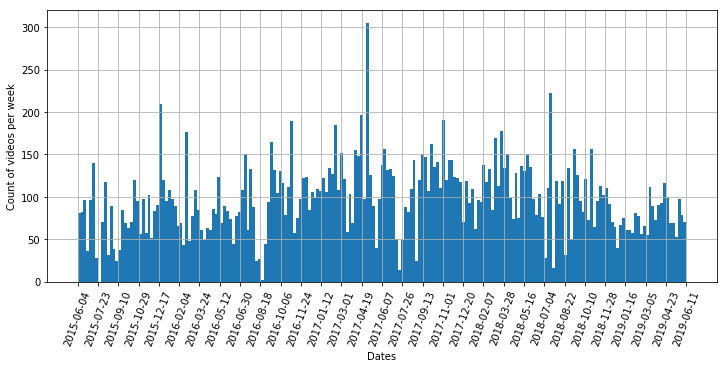

In [9]:
# Dates of data recording
nb_of_elapsed_weeks = int((df.timestamp.astype(int).max() - df.timestamp.astype(int).min())/(60*60*24*7))
def per_week(df,title=''):
    plt.figure(figsize=(12,5))
    plt.title('Dates of data recording')
    n_bins=nb_of_elapsed_weeks
    plt.hist(
        df.timestamp.astype('int'),
        bins=n_bins,
    #     label=dates,
    )
    n_bins_labels = 30
    hist, edges = np.histogram(df.timestamp.astype(int), bins=n_bins_labels)
    dates = [str(date.fromtimestamp(a)) for a in edges]
    plt.xticks(edges, dates, rotation=70)
    plt.grid(True)
    plt.xlabel("Dates")
    plt.ylabel("Count of videos per week")
    plt.title(title)
    plt.show()

per_week(df)

In [10]:
# Basic statistics
hist, edges = np.histogram(df.timestamp.astype(int), bins=nb_of_elapsed_weeks)
print(f"In average, I've clicked on {int(hist.mean()/7)} videos per day...")

hist, edges = np.histogram(df.timestamp.astype(int), bins=nb_of_elapsed_weeks*7)
print(f"With a maximum of {hist.max()} in a single day !")

In average, I've clicked on 13 videos per day...
With a maximum of 109 in a single day !


In [11]:
print("By the way, there are "
     f"{nb_items} videos, "
     f"but there are only {len(df.title.unique())}"
     " unique videos.")

By the way, there are 21178 videos, but there are only 15330 unique videos.


Channels I visit the most :

In [12]:
df_channels = pd.DataFrame(df.groupby('channel').count())
df_channels = df_channels[['tim']]
df_channels.columns = ['count']
df_channels = df_channels.sort_values(by='count',ascending=False)
df_channels.head(25)

,count
channel,
ZeratoR,861
Bazar du Grenier,727
SQUEEZIE,471
Ligue 1 Conforama,283
Dr Nozman,279
HugoDécrypte,275
Bob Lennon,218
Hardisk,202
pvnova,193


On what period have I watched a given channel?

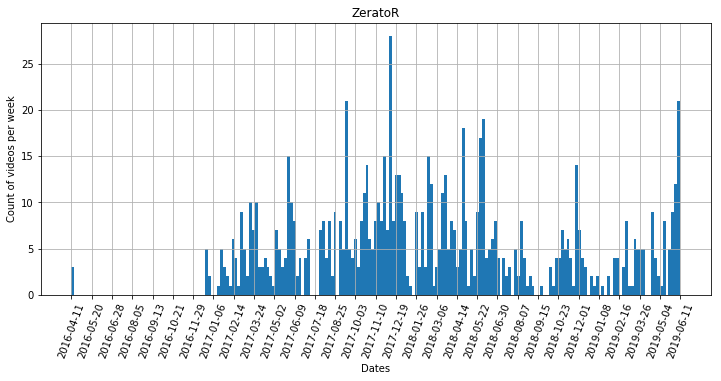

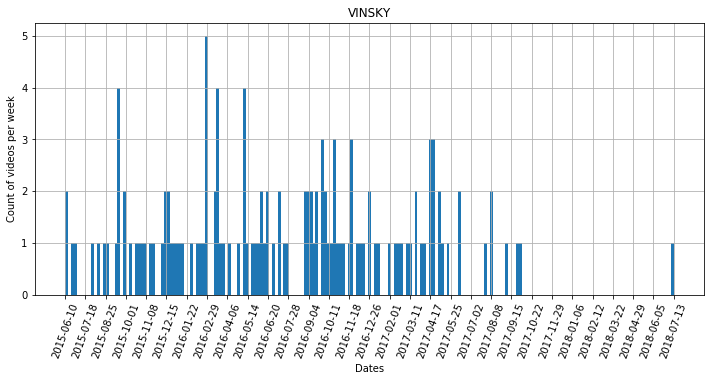

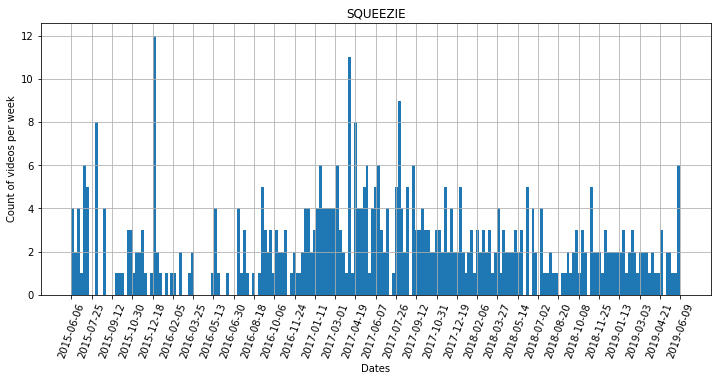

In [13]:
per_week(df.loc[df.channel=='ZeratoR'],title='ZeratoR')

per_week(df.loc[df.channel=='VINSKY'],title='VINSKY')

per_week(df.loc[df.channel=='SQUEEZIE'],title='SQUEEZIE')

What time do I watch videos?

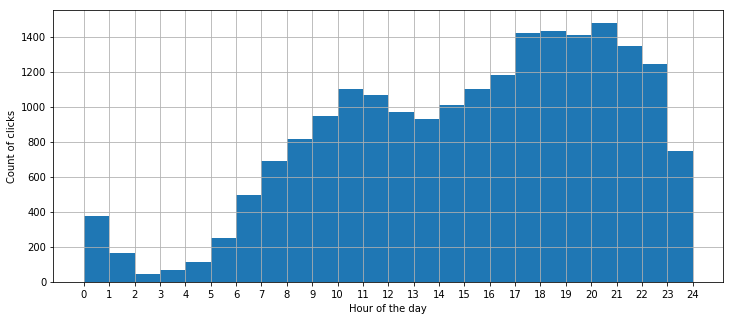

In [14]:
def date_to_minute(date):
    hour, minu = date.split('-')[3:5]
    return 60*int(hour)+int(minu)

def per_hour(minutes,title=''):
    plt.figure(figsize=(12,5))
    plt.hist(minutes, bins=24)
    hist, edges = np.histogram(minutes, bins=24)
    plt.xticks(edges, [ceil(a/60) for a in edges])
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Hour of the day")
    plt.ylabel("Count of clicks")
    plt.show()
    
minutes = df.tim.apply(date_to_minute)
per_hour(minutes)

What about weekdays?

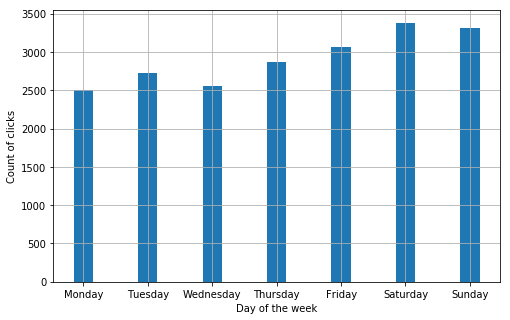

In [15]:
def date_to_weekday(date):
    date = datetime.strptime(date,'%Y-%m-%d-%H-%M-%S')
    return date.weekday()

weekdays = df.tim.apply(date_to_weekday)
plt.figure(figsize=(8,5))
plt.hist(weekdays, range=(-0.5,6.5), bins=7, align='mid', rwidth=0.3)
plt.xticks(list(range(7)), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.grid(True)
plt.xlabel("Day of the week")
plt.ylabel("Count of clicks")
plt.show()

Do I behave similarly on different weekdays?

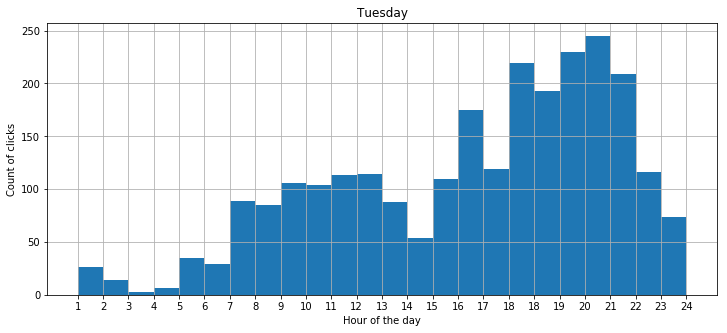

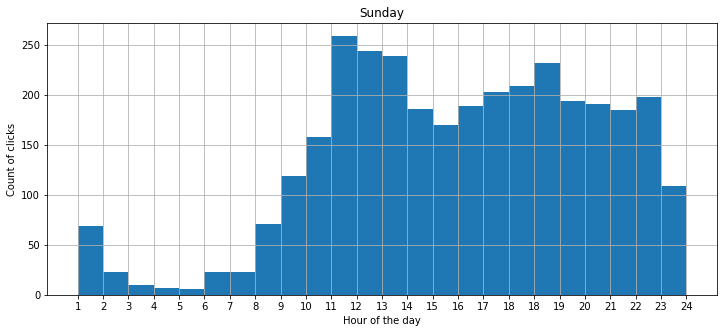

In [16]:
minutes = df.loc[df.tim.apply(date_to_weekday) == 2].tim.apply(date_to_minute)
per_hour(minutes, title='Tuesday')
minutes = df.loc[df.tim.apply(date_to_weekday) == 6].tim.apply(date_to_minute)
per_hour(minutes, title='Sunday')

# Conclusion

At first I was disappointed when I discovered there was nothing about watch time. I was really interested in the question : How long did I spent watching videos? But I finally figured out there was a lot to do with these informations about clicked videos. The most surprising was the channel ranking because it mixes up different parts of my life in a very concrete and unconfortable way.